**MALARIA CELL CLASSIFICATION**

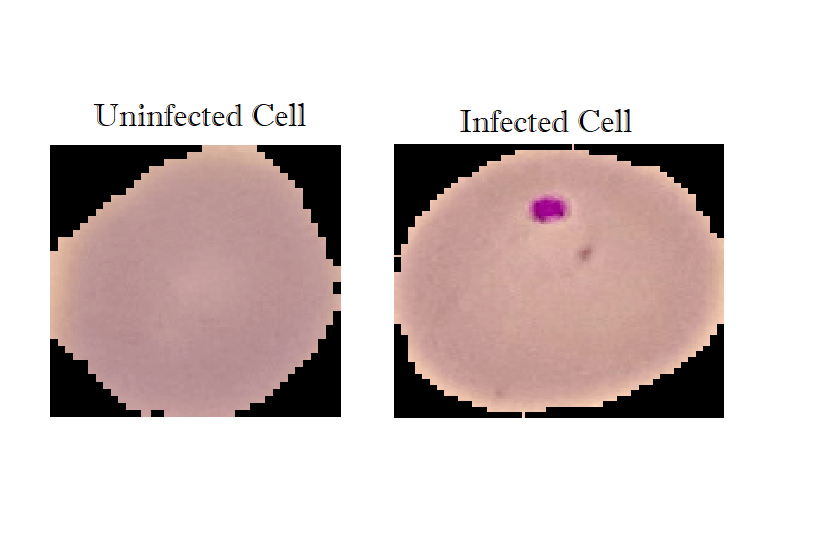

**Downloading the Data**

In [ ]:
! wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip

--2025-04-02 17:35:03--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 3.165.102.96, 3.165.102.126, 3.165.102.109, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|3.165.102.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M   123MB/s    in 2.7s    

2025-04-02 17:35:06 (123 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]



**Extract the Data**

In [ ]:
!unzip /content/cell_images.zip

**Importing necessary packages**

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random
import itertools
import cv2
import os
import seaborn as sb
%matplotlib inline
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Model
import warnings
warnings.filterwarnings('ignore')

**Reading classes and images**

In [ ]:
classes = os.listdir('/content/cell_images')
num_classes = len(classes)
print("{} Classes".format(num_classes))

2 Classes


In [ ]:
total_images = 0
for item in classes:
  total_images += len(os.listdir('/content/cell_images/{}'.format(item)))
#print("{} Images".format(total_images))
print(total_images,"Images")

27560 Images


**Image Data Generator**

In [ ]:
datagen = ImageDataGenerator(
    #rotation_range = 360,
    #horizontal_flip = True,
    #vertical_flip = True,
    rescale = 1./255,
    #shear_range = 0.2,
    #zoom_range = 0.2,
    #height_shift_range = 0.2,
    #width_shift_range = 0.2
)

In [ ]:
train_generator = datagen.flow_from_directory(
    '/content/cell_images',
    target_size = (75,75),
    batch_size = 27560,
    class_mode = 'categorical'
)
X, y = next(train_generator)

Found 27558 images belonging to 2 classes.


In [ ]:
X.shape

(27558, 75, 75, 3)

In [ ]:
y.shape

(27558, 2)

**Visualizing the Data**

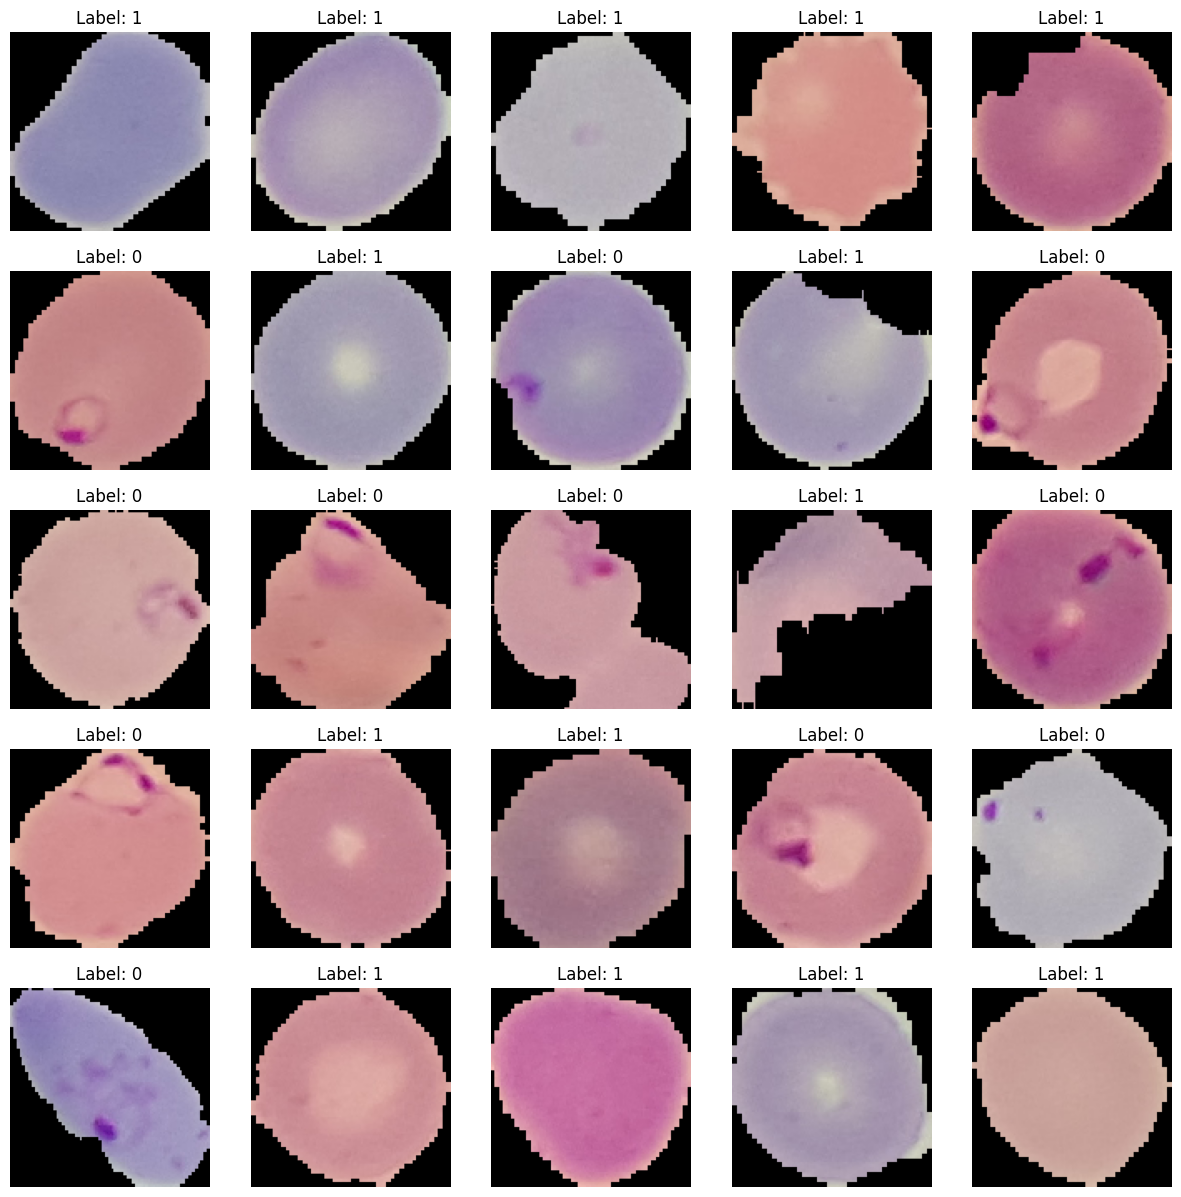

In [ ]:
fig, axes = plt.subplots(5,5, figsize=(15,15))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X.shape[0])
    ax.imshow(X[r])
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Label: '+str(np.argmax(y[r])))

**Train Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(22046, 75, 75, 3)
(5512, 75, 75, 3)
(22046, 2)
(5512, 2)


**Mosquito-Net Architecture**

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(75, 75, 3)),

    tf.keras.layers.Conv2D(16, (5, 5), activation=None, strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),

    tf.keras.layers.Conv2D(32, (5, 5), activation=None, strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),

    tf.keras.layers.Conv2D(64, (5, 5), activation=None, strides=1, padding='same',name = "rr"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='sigmoid'),
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(




> **Note: We use (75,75,3) as our input shape instead of (120,120,3) due to resource constraints**



In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 75, 75, 16)          │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 75, 75, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 37, 37, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 37, 37, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 37, 37, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rr (Conv2D)                          │ (None, 18, 18, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 18, 18, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5184)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,654,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,786,402 (10.63 MB)

 Trainable params: 2,786,178 (10.63 MB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
file='/content/malaria_detection.h5'
checkpointer = ModelCheckpoint(file, monitor='loss',verbose=1,save_best_only=True,save_weights_only=False, mode='auto',save_freq='epoch')
callback_list=[checkpointer]

In [ ]:
result = model.fit(
    X_train, y_train,
    epochs = 20,
    batch_size = 500,
    validation_data = (X_val, y_val),
    verbose = 1,
    callbacks=[callback_list]
)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.5169 - loss: 3.2190
Epoch 1: loss improved from inf to 1.75478, saving model to /content/malaria_detection.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 248ms/step - accuracy: 0.5172 - loss: 3.1871 - val_accuracy: 0.4949 - val_loss: 0.7313
Epoch 2/20
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5994 - loss: 0.6689
Epoch 2: loss improved from 1.75478 to 0.65656, saving model to /content/malaria_detection.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - accuracy: 0.6002 - loss: 0.6684 - val_accuracy: 0.4975 - val_loss: 0.7492
Epoch 3/20
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6912 - loss: 0.5945
Epoch 3: loss improved from 0.65656 to 0.55310, saving model to /content/malaria_detection.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.6928 - loss: 0.5927 - val_accuracy: 0.5051 - val_loss: 1.0465
Epoch 4/20
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8603 - loss: 0.3300
Epoch 4: loss improved from 0.55310 to 0.26813, saving model to /content/malaria_detection.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.8617 - loss: 0.3273 - val_accuracy: 0.4831 - val_loss: 1.0176
Epoch 5/20
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9308 - loss: 0.1989
Epoch 5: loss improved from 0.26813 to 0.17952, saving model to /content/malaria_detection.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.9311 - loss: 0.1980 - val_accuracy: 0.5053 - val_loss: 1.4410
Epoch 6/20
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9480 - loss: 0.1611
Epoch 6: loss improved from 0.17952 to 0.15653, saving model to /content/malaria_detection.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9480 - loss: 0.1609 - val_accuracy: 0.5813 - val_loss: 1.0004
Epoch 7/20
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9522 - loss: 0.1465
Epoch 7: loss improved from 0.15653 to 0.14680, saving model to /content/malaria_detection.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.9522 - loss: 0.1465 - val_accuracy: 0.6134 - val_loss: 0.9496
Epoch 8/20
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9538 - loss: 0.1422
Epoch 8: loss improved from 0.14680 to 0.13435, saving model to /content/malaria_detection.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.9538 - loss: 0.1418 - val_accuracy: 0.7629 - val_loss: 0.6145
Epoch 9/20
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9551 - loss: 0.1316
Epoch 9: loss did not improve from 0.13435
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.9551 - loss: 0.1318 - val_accuracy: 0.9378 - val_loss: 0.1926
Epoch 10/20
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9571 - loss: 0.1259
Epoch 10: loss improved from 0.13435 to 0.12501, saving model to /content/malaria_detection.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9571 - loss: 0.1259 - val_accuracy: 0.9514 - val_loss: 0.1456
Epoch 11/20
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9576 - loss: 0.1258
Epoch 11: loss improved from 0.12501 to 0.11969, saving model to /content/malaria_detection.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.9577 - loss: 0.1255 - val_accuracy: 0.9501 - val_loss: 0.1438
Epoch 12/20
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9593 - loss: 0.1196
Epoch 12: loss improved from 0.11969 to 0.11834, saving model to /content/malaria_detection.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9594 - loss: 0.1195 - val_accuracy: 0.9550 - val_loss: 0.1378
Epoch 13/20
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9607 - loss: 0.1180
Epoch 13: loss did not improve from 0.11834
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.9607 - loss: 0.1181 - val_accuracy: 0.9458 - val_loss: 0.1485
Epoch 14/20
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9627 - loss: 0.1144
Epoch 14: loss improved from 0.11834 to 0.11573, saving model to /content/malaria_detection.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.9626 - loss: 0.1145 - val_accuracy: 0.9554 - val_loss: 0.1337
Epoch 15/20
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9617 - loss: 0.1092
Epoch 15: loss improved from 0.11573 to 0.10924, saving model to /content/malaria_detection.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9617 - loss: 0.1092 - val_accuracy: 0.9568 - val_loss: 0.1474
Epoch 16/20
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9625 - loss: 0.1100
Epoch 16: loss did not improve from 0.10924
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9625 - loss: 0.1100 - val_accuracy: 0.9575 - val_loss: 0.1227
Epoch 17/20
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9626 - loss: 0.1096
Epoch 17: loss improved from 0.10924 to 0.10594, saving model to /content/malaria_detection.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9626 - loss: 0.1095 - val_accuracy: 0.8498 - val_loss: 0.3258
Epoch 18/20
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9651 - loss: 0.0986
Epoch 18: loss improved from 0.10594 to 0.09846, saving model to /content/malaria_detection.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9651 - loss: 0.0986 - val_accuracy: 0.9552 - val_loss: 0.1277
Epoch 19/20
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9653 - loss: 0.1022
Epoch 19: loss did not improve from 0.09846
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9653 - loss: 0.1022 - val_accuracy: 0.7469 - val_loss: 0.5959
Epoch 20/20
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9675 - loss: 0.0969
Epoch 20: loss improved from 0.09846 to 0.09817, saving model to /content/malaria_detection.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9674 - loss: 0.0970 - val_accuracy: 0.9588 - val_loss: 0.1245


In [ ]:
model_json = model.to_json()
with open("/content/cnn_architecture_2.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
score = model.evaluate(X_train, y_train)

689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9673 - loss: 0.0896


In [ ]:
score = model.evaluate(X_val, y_val)

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9592 - loss: 0.1240


In [ ]:
r = result.history

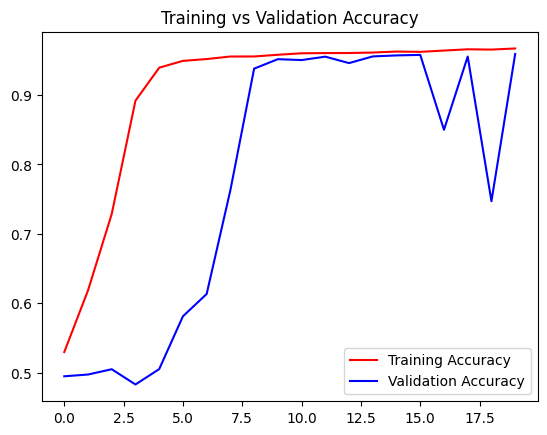

In [ ]:
plt.plot(r['accuracy'],'r',label = 'Training Accuracy')
plt.plot(r['val_accuracy'],'b',label = 'Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

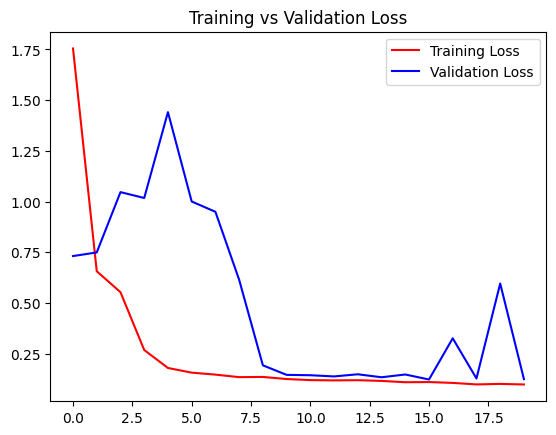

In [ ]:
plt.plot(r['loss'],'r',label = 'Training Loss')
plt.plot(r['val_loss'],'b',label = 'Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
print("Accuracy =",round(max(r['accuracy']),2))
print("Validation accuracy =",round(max(r['val_accuracy']),2))

Accuracy = 0.97
Validation accuracy = 0.96


In [ ]:
y_pred = model.predict(X_val)

173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


In [ ]:
y_pred=np.argmax(y_pred, axis=1)

In [ ]:
y_val=np.argmax(y_val, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
cm = confusion_matrix(y_pred,y_val)
print(cm)

[[2648   91]
 [ 136 2637]]


Confusion matrix
[[2648   91]
 [ 136 2637]]


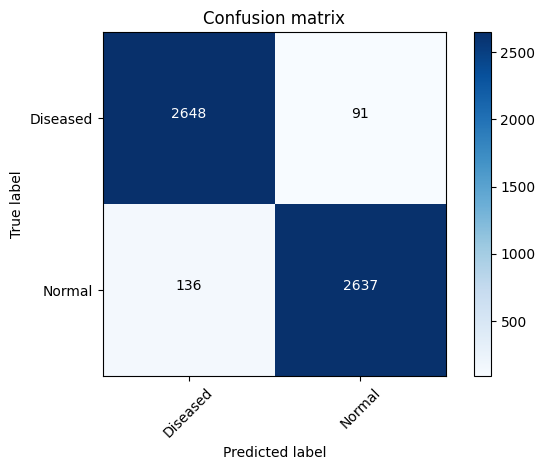

In [ ]:
plt.figure()
plot_confusion_matrix(cm, classes=['Diseased','Normal'],
                      title='Confusion matrix')

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_pred,y_val).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  2648
False Positives:  91
False Negatives:  136
True Positives:  2637


In [ ]:
Accuracy = (tn+tp)*100/(tp+tn+fp+fn)
print("Accuracy {:0.2f}%:".format(Accuracy))

Accuracy 95.88%:


In [ ]:
Precision = tp/(tp+fp)
print("Precision {:0.2f}".format(Precision))

Precision 0.97


In [ ]:
Recall = tp/(tp+fn)
print("Recall {:0.2f}".format(Recall))

Recall 0.95


In [ ]:
f1 = (2*Precision*Recall)/(Precision + Recall)
print("F1 Score {:0.2f}".format(f1))

F1 Score 0.96


In [ ]:
print(classification_report(y_pred,y_val))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2739
           1       0.97      0.95      0.96      2773

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512



**Making Predictions**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


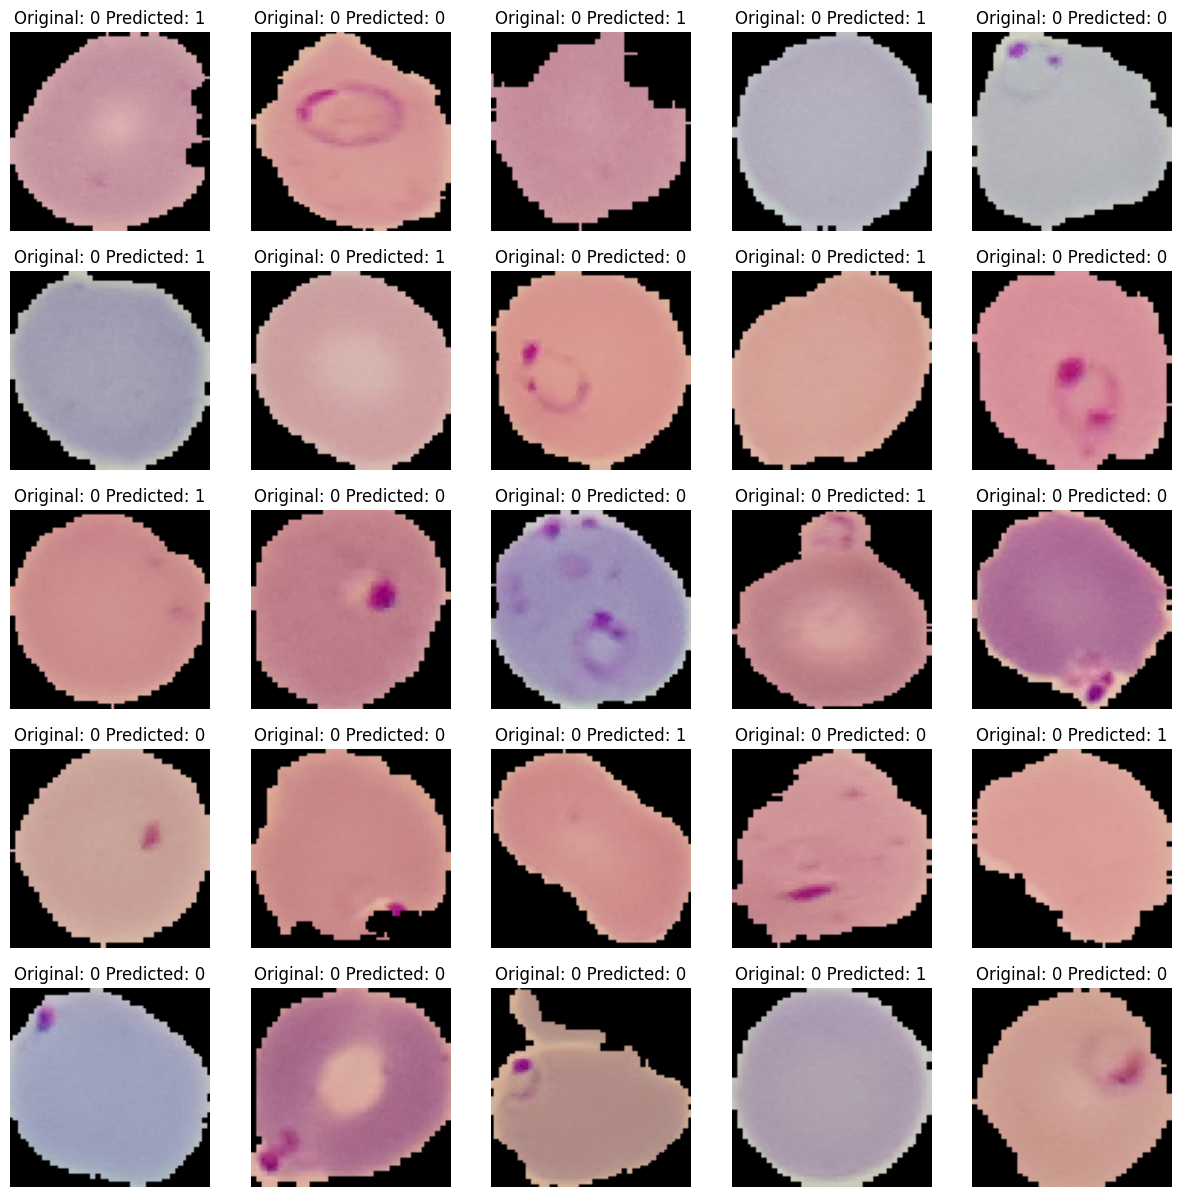

In [ ]:
fig, axes = plt.subplots(5,5, figsize=(15,15))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X_val.shape[0])
    ax.imshow(X_val[r])
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Original: {} Predicted: {}'.format(np.argmax(y_val[r]), np.argmax(model.predict(X_val[r].reshape(1, 75, 75, 3)))))

**NOTE - Things to improve**


- Concentrate on False Negatives
- The reason for concentrating on false negatives is that we are predicting infected patients, so a patient without malaria predicting as malaria is not a problem (ie. False Positives). But a patient with malaria predicting as not is a risk factor, therefore we need to concentrate on false negatives

**Final Part**

**HOT SPOT PREDICTIONS**

- Before we developed a model that classifies malaria cell
- Our main aim is to identify the area that causes prediction probabilities
- Like viewing CNN architecture layer by layer
- Our final layer maps the area that makes the predictions.

In [ ]:
def grad_cam(model, img, last_layer = "dense_2",
             layer_name="rr", label_name=None,
             category_id=None):

    img_tensor = np.expand_dims(img, axis=0)

    conv_layer = model.get_layer(layer_name)
    heatmap_model = keras.models.Model([model.inputs],[model.get_layer(layer_name).output,
                                     model.get_layer(last_layer).output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        gtape.watch(conv_output)
        if category_id == None:
            category_id = np.argmax(predictions[0])
        if label_name:
            print(label_name[category_id])
        output = predictions[:, category_id]
        output = tf.reduce_sum(output)
        # print(conv_output.shape, predictions.shape)  # Should match expected sizes
        grads = gtape.gradient(output, conv_output)
        # print("Predictions:", predictions)  # Debug: Print predictions
        print("Conv Output Shape:", conv_output.shape)  # Debug: Print conv output shape
        # print("Gradients:", grads)  # Debug: Print gradients

        # Ensure gradients are calculated correctly
        if grads is None:
            raise ValueError("Gradients not computed. Check the model and input data.")
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = tf.reduce_mean(conv_output * tf.reshape(pooled_grads, (1, 1, 1, -1)), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return np.squeeze(heatmap),category_id

In [ ]:
def show_imgwithheat(img_path, heatmap, alpha=0.4, return_array=False):
    img = image.img_to_array(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (heatmap*255).astype("uint8")
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    imgwithheat = Image.fromarray(superimposed_img)
    return imgwithheat

In [ ]:
image_file = '/content/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [ ]:
image_file = '/content/cell_images/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_144.png'

In [ ]:
image_file = "/content/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_163.png"

In [ ]:
img_path = Image.open(image_file)

In [ ]:
def preprocess(img_path):#, target_size=(75, 75)):
    img = img_path.resize((75,75))
    img = image.img_to_array(img)
    # img = np.expand_dims(img, axis=0)
    img /= 255

    return img

In [ ]:
img = preprocess(img_path)

In [ ]:
img.shape

(75, 75, 3)

Defected
Conv Output Shape: (1, 18, 18, 64)


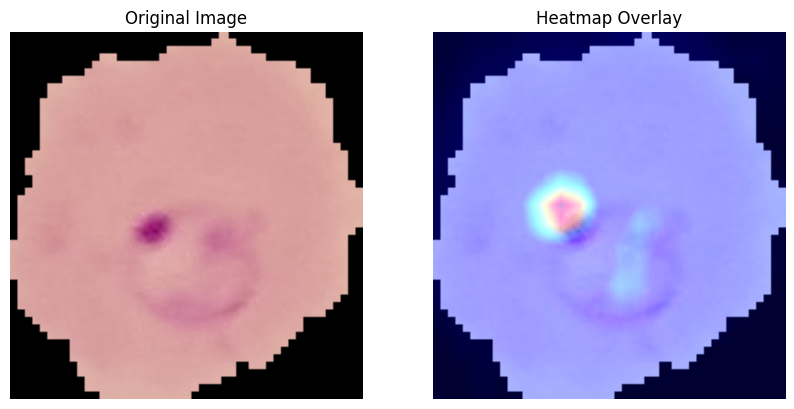

In [ ]:
original_img = Image.open(image_file)
heatmap, label = grad_cam(model, img, label_name=['Defected', 'Normal'])
result = show_imgwithheat(img_path, heatmap)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(result)
plt.title("Heatmap Overlay")
plt.axis("off")

plt.show()

Normal
Conv Output Shape: (1, 18, 18, 64)


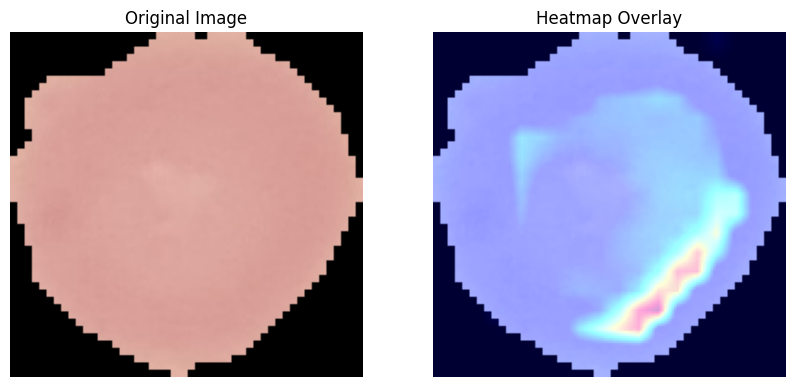

In [ ]:
original_img = Image.open(image_file)
heatmap, label = grad_cam(model, img, label_name=['Defected', 'Normal'])
result = show_imgwithheat(img_path, heatmap)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(result)
plt.title("Heatmap Overlay")
plt.axis("off")

plt.show()

Defected
Conv Output Shape: (1, 18, 18, 64)


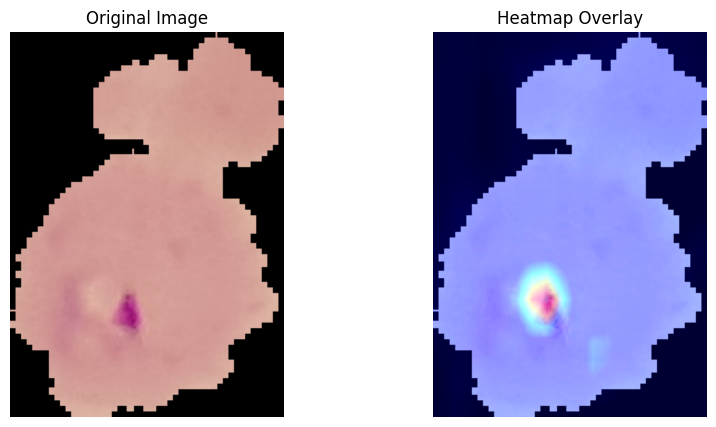

In [ ]:
original_img = Image.open(image_file)
heatmap, label = grad_cam(model, img, label_name=['Defected', 'Normal'])
result = show_imgwithheat(img_path, heatmap)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(result)
plt.title("Heatmap Overlay")
plt.axis("off")

plt.show()